#### 1. **Model Runner Step Sync And Async Testing**

Notebook tests `ModelRunnerStep` within a serving graph to enable real-time monitoring and drift detection with MLRun. 
The main focus is to test te preformance of sync and async usage.

In [1]:
# Import mlrun and create project instance
import mlrun

image = "mlrun/mlrun"
project_name = "monitored-model-runner-naive"
project = mlrun.get_or_create_project(project_name, context="./",user_project=True, allow_cross_project=True)

> 2025-10-29 08:20:30,490 [info] Project loaded successfully: {"project_name":"monitored-model-runner-naive-matanz"}


In [2]:
# Import tools
import pandas as pd
from sklearn.svm import SVC
import pickle
from sklearn.datasets import load_iris
from mlrun.features import Feature

In [3]:
# Train simple SVM model on Iris dataset, save it and reformat the DS as list
iris = load_iris()
clf = SVC()           
clf.fit(iris.data, iris.target)
with open("SVM.pkl", "wb") as fh:
    pickle.dump(clf, fh)
iris_data = iris["data"].tolist()

# load the dataset again as a DF
iris = load_iris()
train_set = pd.DataFrame(
    iris["data"],
    columns=["sepal_length_cm", "sepal_width_cm", "petal_length_cm", "petal_width_cm"],
)

# Create a Model Artifact in the project using the trained model
model_name = "SVM"
model_artifact = project.log_model(
    model_name,
    model_file="SVM.pkl",
    training_set=train_set,
    framework="sklearn",
    outputs=[Feature(name="label")],
)

#### 5. Define your function and ModelRunnerStep

Define functions to all the edge cases

In [4]:
# Config the code path and the serving function sync and async
bouth_code_path = r"model_class_bouth.py"

function = project.set_function(func=bouth_code_path,image="mlrun/mlrun",kind="serving",name="bouth")

In [5]:
from mlrun.serving.states import ModelRunnerStep

model_runner_step = ModelRunnerStep(
    name="my_runner", model_selector="MyModelSelector",model_selector_parameters={"name":"my-selector"})

for i in range(1000):
    model_runner_step.add_model(
        model_class="MyModel",
        endpoint_name=f"my-{i}-model",
        model_artifact=model_artifact,
        input_path="inputs.here",
        result_path="outputs",
        outputs=["label"],
        execution_mechanism="thread_pool",
    )

#### 6. Build graphs to all the edge cases

description


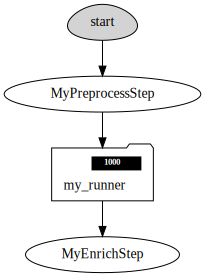

In [6]:
async_graph_undefined = function.set_topology("flow",engine="async")
async_graph_undefined.to("MyPreprocessStep").to(model_runner_step).to("MyEnrichStep").respond()
async_graph_undefined.plot()


#### Run using mock

descteption

In [7]:
# 4. create mock server and test it locally (no k8s / deployment)

mock_server = function.to_mock_server()

> 2025-10-29 08:20:33,330 [info] Server graph after adding system steps: {"graph":"{'MyPreprocessStep': {'class_name': 'MyPreprocessStep', 'kind': 'task'}, 'my_runner': {'model_endpoint_creation_strategy': 'skip', 'class_name': 'mlrun.serving.ModelRunner', 'after': ['MyPreprocessStep'], 'kind': 'model_runner', 'shape': 'folder', 'endpoint_type': 1, 'raise_exception': True, 'class_args': {'model_selector': ('MyModelSelector', {'name': 'my-selector'}), execution_mechanism_by_model_name: {'my-0-model': 'thread_pool', 'my-1-model': 'thread_pool', 'my-2-model': 'thread_pool', 'my-3-model': 'thread_pool', 'my-4-model': 'thread_pool', 'my-5-model': 'thread_pool', 'my-6-model': 'thread_pool', 'my-7-model': 'thread_pool', 'my-8-model': 'thread_pool', 'my-9-model': 'thread_pool', 'my-10-model': 'thread_pool', 'my-11-model': 'thread_pool', 'my-12-model': 'thread_pool', 'my-13-model': 'thread_pool', 'my-14-model': 'thread_pool', 'my-15-model': 'thread_pool', 'my-16-model': 'thread_pool', 'my-17-mo

In [8]:
mock_server

In [ ]:
from random import choice
from datetime import datetime

iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")

time_before = datetime.now()
print("Before invoke:", time_before.strftime("%H:%M:%S.%f"))
moke_response = mock_server.test(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
time_after = datetime.now()
print("After invoke:", time_after.strftime("%H:%M:%S.%f"))
total_time = (time_after - time_before).total_seconds()



In [ ]:
print(f"Total time: {total_time:.3f} seconds")

In [10]:
#moke_response

{'my-0-model': {'outputs': {'label': [1, 1]}},
 'my-1-model': {'outputs': {'label': [1, 1]}},
 'my-2-model': {'outputs': {'label': [1, 1]}},
 'my-3-model': {'outputs': {'label': [1, 1]}},
 'my-4-model': {'outputs': {'label': [1, 1]}},
 'my-5-model': {'outputs': {'label': [1, 1]}},
 'my-6-model': {'outputs': {'label': [1, 1]}},
 'my-7-model': {'outputs': {'label': [1, 1]}},
 'my-8-model': {'outputs': {'label': [1, 1]}},
 'my-9-model': {'outputs': {'label': [1, 1]}},
 'my-10-model': {'outputs': {'label': [1, 1]}},
 'my-11-model': {'outputs': {'label': [1, 1]}},
 'my-12-model': {'outputs': {'label': [1, 1]}},
 'my-13-model': {'outputs': {'label': [1, 1]}},
 'my-14-model': {'outputs': {'label': [1, 1]}},
 'my-15-model': {'outputs': {'label': [1, 1]}},
 'my-16-model': {'outputs': {'label': [1, 1]}},
 'my-17-model': {'outputs': {'label': [1, 1]}},
 'my-18-model': {'outputs': {'label': [1, 1]}},
 'my-19-model': {'outputs': {'label': [1, 1]}},
 'my-20-model': {'outputs': {'label': [1, 1]}},
 '

#### 7. Deploying Your Function

Running this cell will deploy your serving function to the cluster. This also deploys the real-time monitoring functions for your project, which are configured to track the serving function's performance and detect model drift.

In [11]:
function.deploy()

> 2025-10-29 08:21:30,118 [info] Starting remote function deploy
2025-10-29 08:21:30  (info) Deploying function
2025-10-29 08:21:30  (info) Building
2025-10-29 08:21:30  (info) Staging files and preparing base images
2025-10-29 08:21:30  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-10-29 08:21:30  (info) Building processor image
2025-10-29 08:22:16  (info) Build complete
2025-10-29 08:22:45  (info) Function deploy complete
> 2025-10-29 08:22:52,940 [info] Model endpoint creation task completed with state succeeded
> 2025-10-29 08:22:52,940 [info] Successfully deployed function: {"external_invocation_urls":["monitored-model-runner-naive-matanz-bouth.default-tenant.app.cust-cs-il.iguazio-cd0.com/"],"internal_invocation_urls":["nuclio-monitored-model-runner-naive-matanz-bouth.default-tenant.svc.cluster.local:8080"]}


'http://monitored-model-runner-naive-matanz-bouth.default-tenant.app.cust-cs-il.iguazio-cd0.com/'

In [12]:
iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")


print("Before async_sync_function invoke:", datetime.now().strftime("%H:%M:%S.%f"))
deploy_response = function.invoke(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
print("After invoke:", datetime.now().strftime("%H:%M:%S.%f"))
total_time = (time_after - time_before).total_seconds()


Data point:[6.6, 3.0, 4.4, 1.4]
Before async_sync_function invoke: 08:22:53.101438
After invoke: 08:23:25.272696


In [ ]:
print(f"Total time: {total_time:.3f} seconds")

In [13]:
#deploy_response

{'my-0-model': {'outputs': {'label': [1, 1]}},
 'my-1-model': {'outputs': {'label': [1, 1]}},
 'my-2-model': {'outputs': {'label': [1, 1]}},
 'my-3-model': {'outputs': {'label': [1, 1]}},
 'my-4-model': {'outputs': {'label': [1, 1]}},
 'my-5-model': {'outputs': {'label': [1, 1]}},
 'my-6-model': {'outputs': {'label': [1, 1]}},
 'my-7-model': {'outputs': {'label': [1, 1]}},
 'my-8-model': {'outputs': {'label': [1, 1]}},
 'my-9-model': {'outputs': {'label': [1, 1]}},
 'my-10-model': {'outputs': {'label': [1, 1]}},
 'my-11-model': {'outputs': {'label': [1, 1]}},
 'my-12-model': {'outputs': {'label': [1, 1]}},
 'my-13-model': {'outputs': {'label': [1, 1]}},
 'my-14-model': {'outputs': {'label': [1, 1]}},
 'my-15-model': {'outputs': {'label': [1, 1]}},
 'my-16-model': {'outputs': {'label': [1, 1]}},
 'my-17-model': {'outputs': {'label': [1, 1]}},
 'my-18-model': {'outputs': {'label': [1, 1]}},
 'my-19-model': {'outputs': {'label': [1, 1]}},
 'my-20-model': {'outputs': {'label': [1, 1]}},
 '